In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdFingerprintGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# This is new class for blending
from blending_classification import BlendingClassifier

datadir = os.path.join(RDConfig.RDDocsDir, "Book/data")
print(rdBase.rdkitVersion)

2018.09.1


In [2]:
def mols2feat(mols):
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=2)
    res = []
    for mol in mols:
        fp = generator.GetFingerprint(mol)
        arr = np.zeros(0,)
        DataStructs.ConvertToNumpyArray(fp, arr)
        res.append(arr)
    return res

In [3]:
# load train and test data
train_mol = [ mol for mol in Chem.SDMolSupplier(os.path.join(datadir,'solubility.train.sdf')) if mol != None]
test_mol = [ mol for mol in Chem.SDMolSupplier(os.path.join(datadir,'solubility.test.sdf')) if mol != None]

cls = list(set([mol.GetProp('SOL_classification') for mol in train_mol]))
cls_dic = {}
for i, cl in enumerate(cls):
    cls_dic[cl] = i


In [4]:
# make train X, y and test X, y
train_X = np.array(mols2feat(train_mol))
train_y = np.array([cls_dic[mol.GetProp('SOL_classification')] for mol in train_mol])

test_X = np.array(mols2feat(test_mol))
test_y = np.array([cls_dic[mol.GetProp('SOL_classification')] for mol in test_mol])

In [5]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)
gbc = GradientBoostingClassifier(learning_rate=0.01)
xgbc = XGBClassifier(n_estimators=100, n_jobs=-1)
# To use SVC, probability option must be True
svc = SVC(probability=True, gamma='auto')

l1_clfs = [rf, et, gbc, xgbc]
l2_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [6]:
blendclf = BlendingClassifier(l1_clfs, l2_clf, verbose=1)

In [7]:
blendclf.fit(train_X, train_y)

Fitting 4 l1_classifiers...
3 classes classification
1-1th hold, <class 'sklearn.ensemble.forest.RandomForestClassifier'> classifier
1-2th hold, <class 'sklearn.ensemble.forest.RandomForestClassifier'> classifier
1-3th hold, <class 'sklearn.ensemble.forest.RandomForestClassifier'> classifier
1-4th hold, <class 'sklearn.ensemble.forest.RandomForestClassifier'> classifier
1-5th hold, <class 'sklearn.ensemble.forest.RandomForestClassifier'> classifier
2-1th hold, <class 'sklearn.ensemble.forest.ExtraTreesClassifier'> classifier
2-2th hold, <class 'sklearn.ensemble.forest.ExtraTreesClassifier'> classifier
2-3th hold, <class 'sklearn.ensemble.forest.ExtraTreesClassifier'> classifier
2-4th hold, <class 'sklearn.ensemble.forest.ExtraTreesClassifier'> classifier
2-5th hold, <class 'sklearn.ensemble.forest.ExtraTreesClassifier'> classifier
3-1th hold, <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> classifier
3-2th hold, <class 'sklearn.ensemble.gradient_boosting.Gradien

BlendingClassifier(l1_clfs=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fract...state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)],
          l2_clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_hold=5, random_state=794, test_size=0.2, use_clones=True,
          verbose=1)

In [8]:
pred_y = blendclf.predict(test_X)

In [9]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       102
           1       0.69      0.61      0.65       115
           2       0.56      0.70      0.62        40

   micro avg       0.70      0.70      0.70       257
   macro avg       0.67      0.70      0.68       257
weighted avg       0.70      0.70      0.70       257



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1c119f60>)

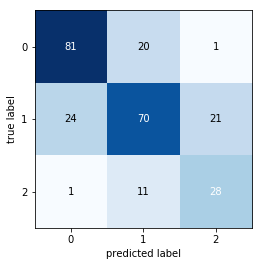

In [10]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(test_y, pred_y)
plot_confusion_matrix(cm)

In [11]:
mono_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
mono_rf.fit(train_X, train_y)
pred_y2 = mono_rf.predict(test_X) 
print(classification_report(test_y, pred_y2))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       102
           1       0.77      0.75      0.76       115
           2       0.72      0.78      0.75        40

   micro avg       0.78      0.78      0.78       257
   macro avg       0.77      0.78      0.77       257
weighted avg       0.78      0.78      0.78       257



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10a425630>)

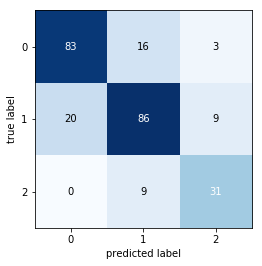

In [12]:
cm2 = confusion_matrix(test_y, pred_y2)
plot_confusion_matrix(cm2)